# Visualization

> Necessary scripts to visualize orbits

In [1]:
#| default_exp visualize

In [2]:
#| export
#| hide
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from typing import Optional, List, Dict

In [3]:
#| hide
from pytest import raises

## Static

In [4]:
#| export
def visualize_static_orbits(data: np.ndarray,  # The orbit data with shape (num_orbits, 6, num_time_points).
                            time_instants: Optional[List[int]] = None,  # Time points to highlight; defaults to None.
                            orbit_indices: Optional[List[int]] = None,  # Indices of orbits to visualize; defaults to all.
                            point_dict: Optional[Dict[str, tuple]] = None,  # Dictionary of extra points to plot.
                            show_legend: bool = True,  # Flag to indicate whether to show a legend.
                            save_path: Optional[str] = None,  # Path to save the figure; defaults to None.
                            plot_reference_box: bool = True  # Flag to indicate whether to plot the reference box.
                           ) -> None:
    """
    Visualizes orbits in 3D space and highlights specified time instants for each selected orbit.
    """
    if time_instants is None:
        time_instants = []  # Initialize to empty list if None.

    # Validate time instants are within the range of available time points.
    max_time_instants = data.shape[2]
    for time_instant in time_instants:
        if time_instant < 0 or time_instant >= max_time_instants:
            raise ValueError(f"Time instant {time_instant} is out of range.")

    # Validate orbit indices are within the range of available orbits.
    num_orbits = data.shape[0]
    if orbit_indices is None:
        orbit_indices = range(num_orbits)  # Use all orbits by default.
    else:
        for index in orbit_indices:
            if index < 0 or index >= num_orbits:
                raise ValueError(f"Orbit index {index} is out of range.")

    # Setup a 3D plot.
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot each selected orbit.
    for index in orbit_indices:
        X = data[index, 0, :]  # X coordinates
        Y = data[index, 1, :]  # Y coordinates
        Z = data[index, 2, :]  # Z coordinates
        ax.plot(X, Y, Z, label=f'Orbit {index}', alpha=0.5)  # Plot each orbit with a label.

    # Generate a color map for time instants if they exist.
    colors = plt.cm.jet(np.linspace(0, 1, len(time_instants)))

    # Highlight specified time instants and add to the legend.
    legend_added = set()  # Track which labels have been added to the legend
    if time_instants:
        for time_instant, color in zip(time_instants, colors):
            for index in orbit_indices:
                posx, posy, posz = data[index, 0:3, time_instant]
                label = f'Time {time_instant}'
                if label not in legend_added:
                    ax.scatter(posx, posy, posz, color=color, s=100, zorder=5, label=label)
                    legend_added.add(label)
                else:
                    ax.scatter(posx, posy, posz, color=color, s=100, zorder=5)

    # Plot additional points if provided.
    if point_dict:
        for point_name, coords in point_dict.items():
            ax.scatter(*coords, label=point_name, s=100, depthshade=True)  # Always add label for point_dict entries.

    # Set labels and title.
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('3D Orbits Static Visualization')

    # Display the legend if requested.
    if show_legend:
        ax.legend()

    # Set the background color and plot reference box if requested.
    if plot_reference_box:
        ax.set_facecolor('white')  # White background
        ax.grid(True)  # Show grid
        # Set limits for the reference box
        ax.set_xlim([data[:, 0, :].min(), data[:, 0, :].max()])
        ax.set_ylim([data[:, 1, :].min(), data[:, 1, :].max()])
        ax.set_zlim([data[:, 2, :].min(), data[:, 2, :].max()])
    else:
        ax.set_facecolor('white')
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

    # Save the figure if a save path is provided.
    if save_path:
        plt.savefig(save_path)

    # Show the plot.
    plt.show()

In [5]:
#| test
from orbit_generation.data import get_example_orbit_data
from orbit_generation.constants import EM_POINTS

In [6]:
#| test
orbit_data= get_example_orbit_data()
orbit_data.shape

(200, 6, 300)

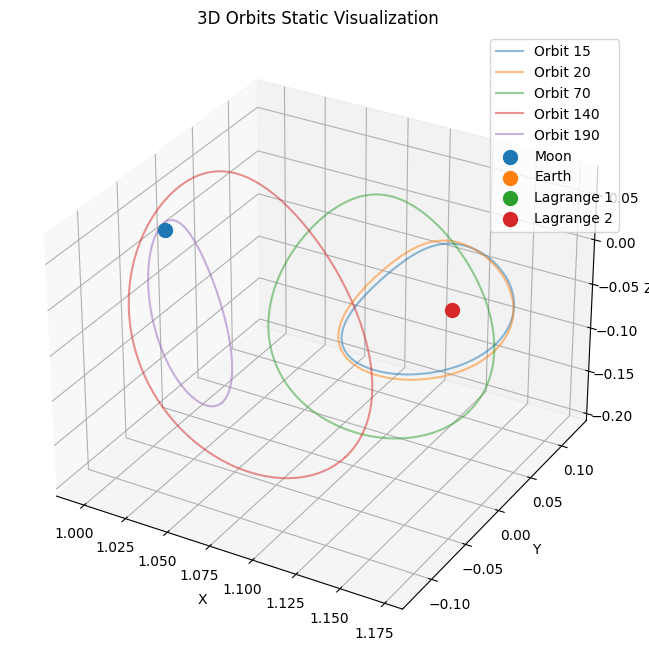

In [7]:
visualize_static_orbits(data= orbit_data, orbit_indices=[15,20,70,140,190], point_dict=EM_POINTS)

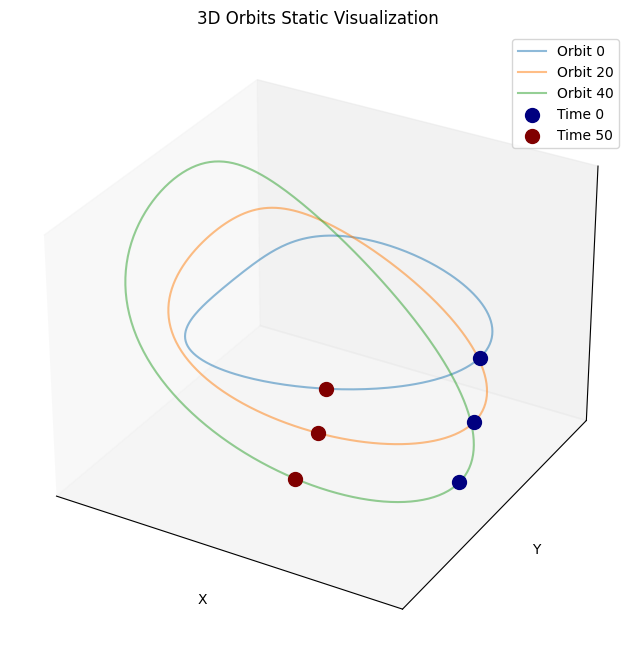

In [8]:
visualize_static_orbits(data= orbit_data,time_instants=[0,50], orbit_indices=[0,20,40], plot_reference_box=False)

In [9]:
#| hide
#| test "invalid time_instants raises ValueError"
time_instants = [-1, 11]  # Out of bounds
with raises(ValueError):
    visualize_static_orbits(orbit_data, time_instants)

#| test "invalid orbit_indices raises ValueError"
time_instants = [0, 9]  # Valid
orbit_indices = [201]  # Out of bounds
with raises(ValueError) as exception_info:
    visualize_static_orbits(orbit_data, time_instants, orbit_indices)
assert "Orbit index 201 is out of range." in str(exception_info.value)

## Dynamic

In [10]:
#| export
def export_dynamic_orbits_html(data: np.ndarray,  # Orbit data as a 3D numpy array (num_orbits, 6, num_time_points).
                               time_instants: Optional[List[int]] = None,  # Time instants to highlight.
                               orbit_indices: Optional[List[int]] = None,  # Indices of orbits to visualize.
                               point_dict: Optional[Dict[str, tuple]] = None,  # Named points as a dict with 3D coordinates.
                               filename: str = 'orbits.html'  # Path and name of the file to save the HTML plot.
                               ) -> None:
    """
    Generates an interactive 3D visualization of orbits and saves it as an HTML file, including the ability to
    highlight specific time instants and show named points.
    """
    if time_instants is None:
        time_instants = []  # Ensure time_instants is initialized if None.

    num_orbits = data.shape[0]  # Total number of orbits in the dataset.
    if orbit_indices is None:
        orbit_indices = list(range(num_orbits))  # Default to visualizing all orbits if none specified.

    fig = go.Figure()  # Initialize the plotly figure.

    # Validate and plot each orbit.
    for index in orbit_indices:
        if index < 0 or index >= num_orbits:
            raise ValueError(f"Orbit index {index} is out of range.")
        
        # Extract coordinates for the plot.
        X = data[index, 0, :]  # X coordinates.
        Y = data[index, 1, :]  # Y coordinates.
        Z = data[index, 2, :]  # Z coordinates.
        fig.add_trace(go.Scatter3d(x=X, y=Y, z=Z, mode='lines',
                                   name=f'Orbit {index}',
                                   legendgroup=f'orbit{index}',
                                   showlegend=True))

        # Highlight specific time instants.
        if time_instants:
            for timestamp in time_instants:
                if timestamp < 0 or timestamp >= data.shape[2]:
                    raise ValueError(f"The provided timestamp {timestamp} is out of range.")
                highlight_x = [data[index, 0, timestamp]]
                highlight_y = [data[index, 1, timestamp]]
                highlight_z = [data[index, 2, timestamp]]
                fig.add_trace(go.Scatter3d(x=highlight_x, y=highlight_y, z=highlight_z, mode='markers',
                                           marker=dict(size=5, color='red'),
                                           name=f'Highlight {index} @ {timestamp}',
                                           legendgroup=f'orbit{index}',
                                           showlegend=False))

    # Add additional points from point_dict to the plot.
    if point_dict:
        for point_name, coords in point_dict.items():
            fig.add_trace(go.Scatter3d(x=[coords[0]], y=[coords[1]], z=[coords[2]], mode='markers',
                                       marker=dict(size=5),
                                       name=point_name))

    # Configure the layout of the plot.
    fig.update_layout(title='3D Orbits Visualization',
                      scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                      width=800, height=600,
                      legend_title="Orbits Legend",
                      clickmode='event+select')

    # Write the plot to an HTML file.
    fig.write_html(filename)
    print(f"Visualization saved to {filename}")

In [11]:
export_dynamic_orbits_html(data=orbit_data, filename='../data/example_orbits.html')

Visualization saved to ../data/example_orbits.html


[View Orbit Visualization](../data/example_orbits.html)


In [12]:
#| hide

#| test "invalid time_instants raises ValueError"
data = np.zeros((3, 6, 50))  # Dummy data with 3 orbits, 6 parameters, 50 time points
time_instants = [-1, 51]  # Invalid time_instants
orbit_indices = [0, 1]  # Valid orbit indices
filename = 'test_orbits.html'  # Filename for saving the HTML
with raises(ValueError):
    export_dynamic_orbits_html(data, time_instants, orbit_indices, filename=filename)

#| test "invalid orbit_indices raises ValueError"
time_instants = [10, 20]  # Valid time_instants
orbit_indices = [3, 4]  # Invalid orbit indices (out of range for given data)
with raises(ValueError):
    export_dynamic_orbits_html(data, time_instants, orbit_indices, filename=filename)


In [13]:
#| hide
import nbdev; nbdev.nbdev_export()